In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import re, sqlite3, pickle, time, datetime, random, sys, keras
# sys.path is a list of absolute path strings
sys.path.append('/home/d/dlr10/Documents/02_Statitics_modelling/0_FunctionsScripts')
import Loading_Data_Functions as load_fn
import FineTuning_Functions as FineTuning
import Learning_Curves_Functions as LearningCurves

##############################################################################
# IMPORT DEEP LEARNING PACKAGES
##############################################################################

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Dropout, Flatten, LeakyReLU
from keras import layers

from tensorflow.keras.optimizers import Adam, SGD, RMSprop, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import make_scorer, accuracy_score
LeakyReLU = LeakyReLU(alpha=0.1)

from bayes_opt import BayesianOptimization

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", None)

2022-05-27 18:23:29.429110: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/local/apps/gcc/8.2.0/lib:/cm/local/apps/gcc/8.2.0/lib64:/cm/local/apps/torque/6.1.3/lib
2022-05-27 18:23:29.429151: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [10]:
t    = time.time()
path = r'/home/d/dlr10/Documents/02_Statitics_modelling/DataSets/'

df_patients_16_18, df_admissions_16_18, df_eobs_16_18 = load_fn.Load_data()
df_patients_19_20, df_admissions_19_20, df_eobs_19_20 = load_fn.Load_data('2019_2020')

X_data_curb_16_18 = pickle.load(open(path + 'df_first_curb_2016_18.pickle','rb'))#.drop(columns = 'no_sample_series')
X_data_curb_19_20 = pickle.load(open(path + 'df_first_curb_2019_20.pickle','rb'))#.drop(columns = 'no_sample_series')
print("Elapsed time:", time.time()-t)

Elapsed time: 21.747871160507202


In [41]:
print(len(X_data_curb_16_18[0]['Mortality']))
x  = np.arange(3)
y0 = [len(df[df['Mortality'] == 0]) for df in X_data_curb_16_18]
y1 = [len(df[df['Mortality'] == 1]) for df in X_data_curb_16_18]
pr = np.divide(np.asarray(y1) , (np.asarray(y0) + np.asarray(y1))) * 100
pr

1161


array([ 4.39276486, 10.70395371, 17.99086758])

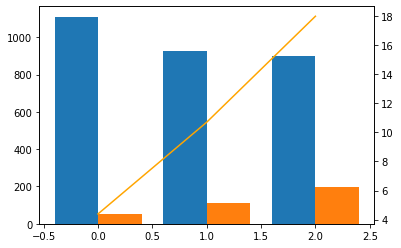

In [44]:
width = 0.4

ax1 = plt.subplot()
plt.bar(x-0.2, y0, width)
plt.bar(x+0.2, y1, width)
ax2 = ax1.twinx()
ax2.plot(pr, color='orange')
plt.show()

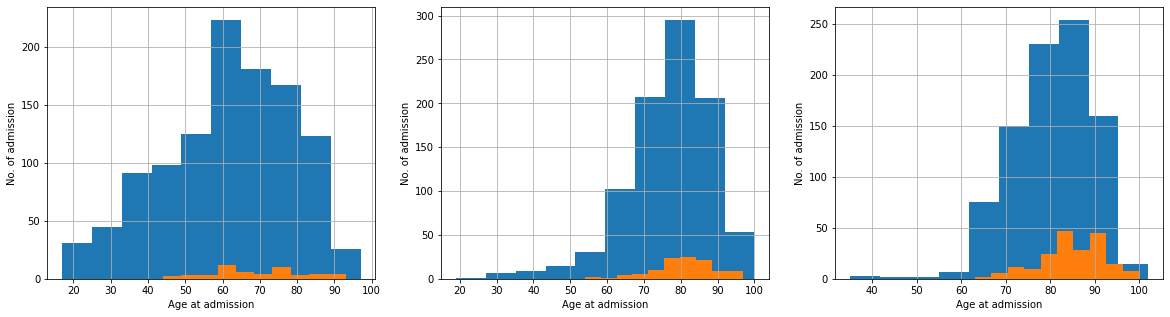

In [59]:
fig, axs = plt.subplots(1,3, figsize = (20,5))
for i in range(3):
    X_data_curb_16_18[i][X_data_curb_16_18[i]['Mortality'] == 0]['age_at_admin'].hist(ax = axs[i])
    X_data_curb_16_18[i][X_data_curb_16_18[i]['Mortality'] == 1]['age_at_admin'].hist(ax = axs[i])
    axs[i].set_xlabel('Age at admission')
    axs[i].set_ylabel('No. of admission')
plt.show()

In [62]:
#######################################
### SPLIT DATA
#######################################
train_set = X_data_16_18
valid_set = X_data_19_20

print('total admissions 16 18', len(X_data_16_18))
print('total admissions 19 20', len(X_data_19_20))
print('X_train', len(train_set))
print('Admissions neg (mortal - class = 0):', len(train_set[train_set['Mortality']==0]),
      'Admissions pos (recover- class = 1):', len(train_set[train_set['Mortality']==1]))
print('X_valid', len(valid_set))
print('Admissions neg (mortal - class = 0):', len(valid_set[valid_set['Mortality']==0]), 
      'Admissions pos (recover- class = 1):', len(valid_set[valid_set['Mortality']==1]))

total admissions 16 18 1161
total admissions 19 20 409
X_train 1161
Admissions neg (mortal - class = 0): 1110 Admissions pos (recover- class = 1): 51
X_valid 409
Admissions neg (mortal - class = 0): 378 Admissions pos (recover- class = 1): 31
